# Importing Libraries & datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_excel("../final_df.xlsx")

# Time Series Analysis


## Hyperparameter Tuning 

### Checking Stationarity of the Data

In [3]:
def adfuller_test(series, series_name, signif=0.05):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= signif:
        print(f" => {series_name} is Stationary. (Reject the null hypothesis)")
    else:
        print(f" => {series_name} is Non-Stationary. (Fail to reject the null hypothesis)")

# Perform Dickey-Fuller test on the data
for i in list(["Quantity", "Clicks", "Impressions"]):
    print(f"ADF Test for {i}:")
    adfuller_test(df[i], i)
    print("-"*70)

ADF Test for Quantity:
ADF Statistic: -4.445717448758575
p-value: 0.00024615679644112006
Critical Values:
	1%: -3.4621857592784546
	5%: -2.875537986778846
	10%: -2.574231080806213
 => Quantity is Stationary. (Reject the null hypothesis)
----------------------------------------------------------------------
ADF Test for Clicks:
ADF Statistic: -0.8705717270828215
p-value: 0.797509057499528
Critical Values:
	1%: -3.4620315036789666
	5%: -2.8754705024827127
	10%: -2.5741950726860647
 => Clicks is Non-Stationary. (Fail to reject the null hypothesis)
----------------------------------------------------------------------
ADF Test for Impressions:
ADF Statistic: -5.6962061101258685
p-value: 7.863580125889645e-07
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557
 => Impressions is Stationary. (Reject the null hypothesis)
----------------------------------------------------------------------


<b><i>Data series is stationary for Quantity and Impressions attribute.

In [4]:
# Function to make a series stationary
def make_stationary(series):
    series_log = np.sqrt(series)
    series_diff = series_log.diff().dropna()
    return series_diff

df["Clicks_stationary"] = make_stationary(df["Clicks"])

<b><i>Making Clicks_stationary

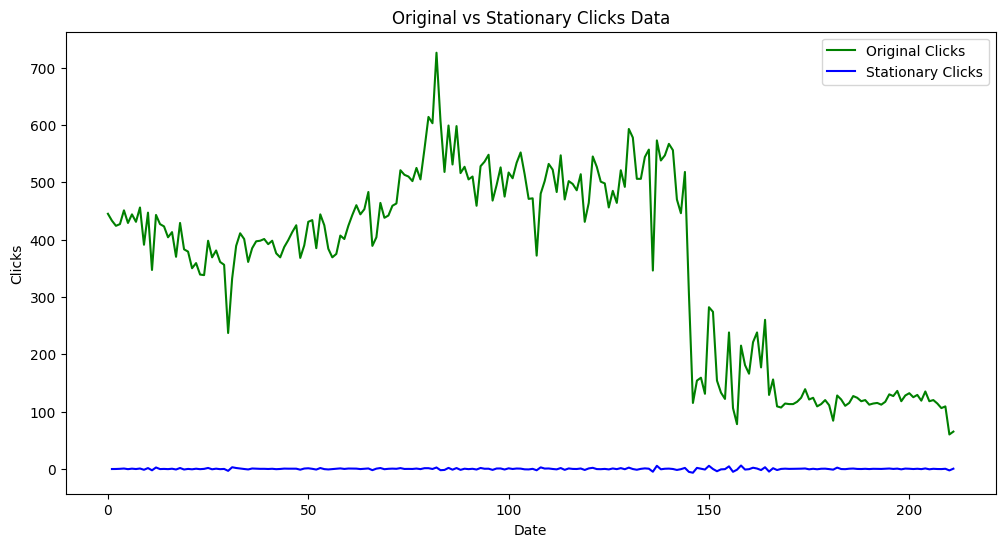

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Clicks'], label='Original Clicks', color='green')
plt.plot(df.index, df['Clicks_stationary'], label='Stationary Clicks', color='blue')
plt.title('Original vs Stationary Clicks Data')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.show()

<b><i>Hence, Clicks_stationary is a stationary series.

### Plotting ACF and PACF plots

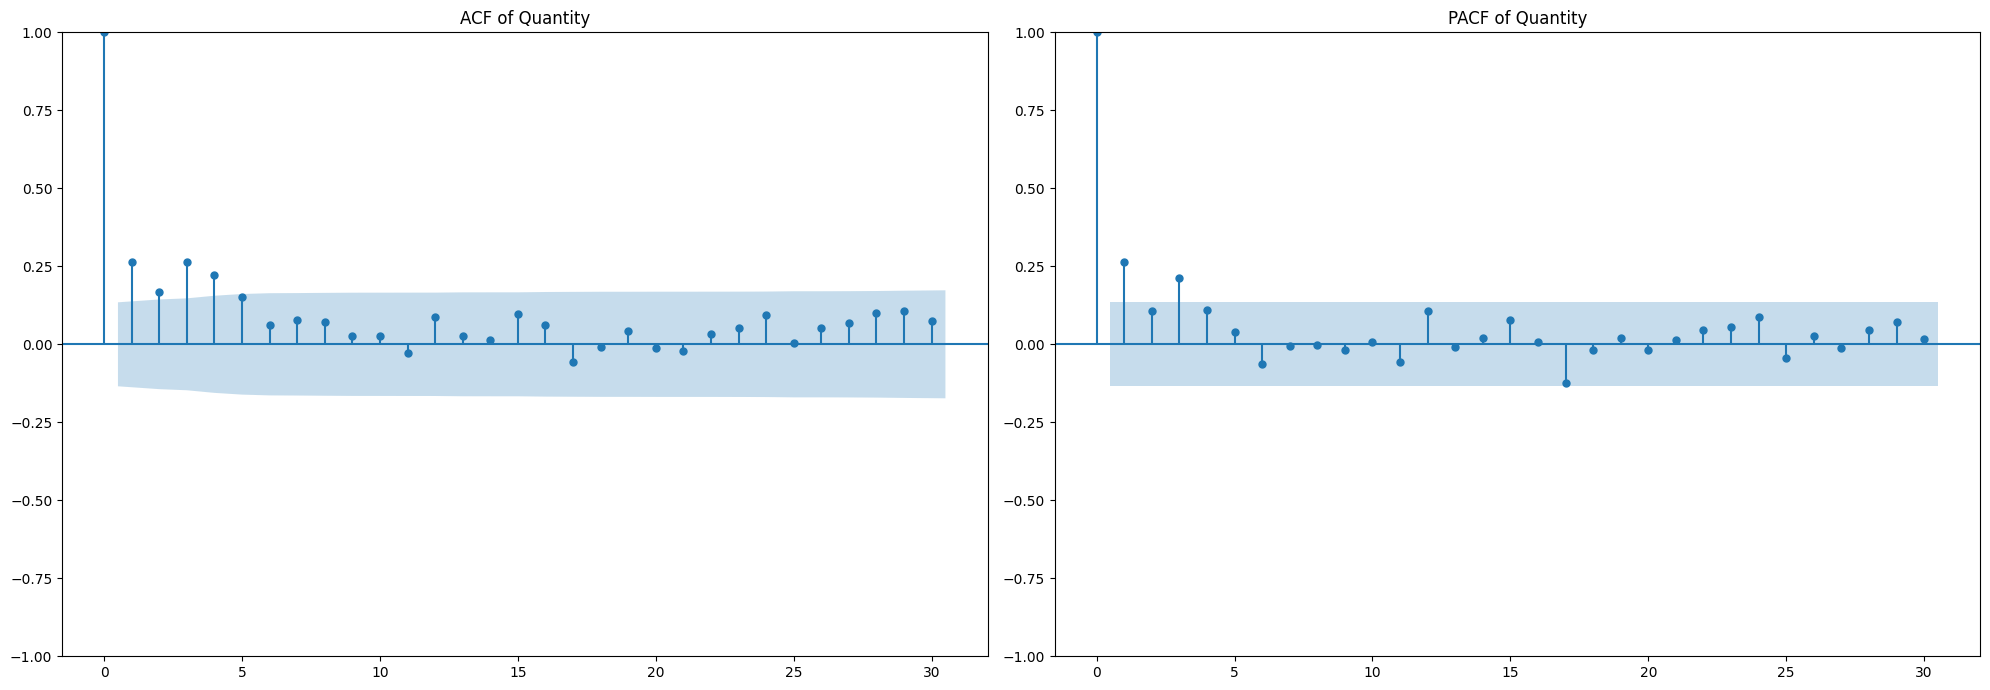

In [6]:
# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# ACF plot
plot_acf(df['Quantity'], lags=30, ax=ax1)
ax1.set_title('ACF of Quantity')

# PACF plot
plot_pacf(df['Quantity'], lags=30, ax=ax2)
ax2.set_title('PACF of Quantity')

plt.tight_layout()
plt.show()


### Determining Optimal Parameters

<i><b>Value of differencing is zero, d = 0.</b> (Since, data series for quantity is stationary)<p>
<i><b>And The value of p = 1 and q = 1 for Quantity.</b> (Since each plot have a single biggest spike)<p>

## Data Splitting

<table>
  <tr>
    <th>Data set</th>
    <th>percentage</th>
    <th>Num of days</th>
  </tr>
  <tr>
    <td>train set</td>
    <td>80 %</td>
    <td>169 days</td>
  </tr>
  <tr>
    <td>validation set</td>
    <td>10 %</td>
    <td>21 days</td>
  </tr>
  <tr>
    <td>test set</td>
    <td>10 %</td>
    <td>22 days</td>
  </tr>
</table>



In [12]:
# Calculate the split indices
train_size = int(0.80 * len(df))
val_size = int(0.10 * len(df))
test_size = len(df) - train_size - val_size

# Split the df
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print("Train Data Size:\t", len(train_df))
print("Validation Data Size:\t", len(val_df))
print("Test Data Size:\t\t", len(test_df))

Train Data Size:	 169
Validation Data Size:	 21
Test Data Size:		 22


## Modelling

#### <i>functions for plotting predictions of models</i>

In [13]:
warnings.filterwarnings("ignore")       # to ignore ny warnings while fitting the model

function for plotting AR, MA, ARMA, ARIMA, SARIMA 

In [14]:
def plot_predictions_and_metrics(train_df, val_df, test_df, model, model_name='Model'):
    # Make predictions
    start_train = 0
    end_train = len(train_df) - 1
    predictions_train = model.predict(start=start_train, end=end_train)

    start_val = len(train_df)
    end_val = start_val + len(val_df) - 1
    predictions_val = model.predict(start=start_val, end=end_val)
    
    start_test = len(train_df) + len(val_df)
    end_test = start_test + len(test_df) - 1
    predictions_test = model.predict(start=start_test, end=end_test)

    # Plot predictions vs actuals for training, validation, and test sets
    plt.figure(figsize=(15, 7))
    plt.plot(train_df.index, train_df['Quantity'], label='Training Data')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation Data')
    plt.plot(test_df.index, test_df['Quantity'], label='Test Data')
    plt.plot(train_df.index, predictions_train, label='Training Predictions', color='blue', linestyle='--')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red', linestyle='--')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='green', linestyle='--')
    plt.title(f'{model_name} - Training vs Validation vs Test')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()
    
    # Calculate evaluation metrics
    def adjusted_r2_score(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    def calculate_metrics(actual, predicted, num_features):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        r2 = r2_score(actual, predicted)
        adj_r2 = adjusted_r2_score(r2, len(actual), num_features)
        return mse.round(3), mae.round(3), mape.round(3), r2.round(3), adj_r2.round(3)

    num_features = len(train_df.columns) - 1  # Subtract 1 for the dependent variable 'Quantity'
    mse_val, mae_val, mape_val, r2_val, adj_r2_val = calculate_metrics(val_df['Quantity'], predictions_val, num_features)
    mse_test, mae_test, mape_test, r2_test, adj_r2_test = calculate_metrics(test_df['Quantity'], predictions_test, num_features)

    # Print evaluation metrics
    print(f'Validation Set Metrics for {model_name}:')
    print(f'MSE: \t\t{mse_val} \nMAE: \t\t{mae_val} \nMAPE: \t\t{mape_val}% \nR2: \t\t{r2_val} \nAdjusted R2: \t{adj_r2_val}')
    print(f'\nTest Set Metrics for {model_name}:')
    print(f'MSE: \t\t{mse_test} \nMAE: \t\t{mae_test} \nMAPE: \t\t{mape_test}% \nR2: \t\t{r2_test} \nAdjusted R2: \t{adj_r2_test}')

function for plotting ARIMAX, SARIMAX

In [15]:
def plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, model, model_name):
    # Generate predictions for the validation set
    predictions_val = model.get_forecast(steps=len(val_df), exog=exog_val).predicted_mean

    # Generate predictions for the test set
    predictions_test = model.get_forecast(steps=len(test_df), exog=exog_test).predicted_mean

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Quantity'], label='Train', color='blue')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation', color='orange')
    plt.plot(test_df.index, test_df['Quantity'], label='Test', color='green')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='purple')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()

    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape 

    # Function to calculate adjusted R² score
    def adjusted_r2_score(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Calculate metrics
    def calculate_metrics(actual, predicted, num_features):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = calculate_mape(actual, predicted)
        r2 = r2_score(actual, predicted)
        adj_r2 = adjusted_r2_score(r2, len(actual), num_features)
        return mse.round(3), mae.round(3), mape.round(3), r2.round(3), adj_r2.round(3)

    num_features = exog_val.shape[1]
    mse_val, mae_val, mape_val, r2_val, adj_r2_val = calculate_metrics(val_df['Quantity'], predictions_val, num_features)
    mse_test, mae_test, mape_test, r2_test, adj_r2_test = calculate_metrics(test_df['Quantity'], predictions_test, num_features)

    # Print metrics
    print(f'{model_name} Validation Set Metrics:')
    print(f'MSE: \t\t{mse_val}')
    print(f'MAE: \t\t{mae_val}')
    print(f'MAPE: \t\t{mape_val}%')
    print(f'R2: \t\t{r2_val}')
    print(f'Adjusted R2: \t{adj_r2_val}')

    print(f'\n{model_name} Test Set Metrics:')
    print(f'MSE: \t\t{mse_test}')
    print(f'MAE: \t\t{mae_test}')
    print(f'MAPE: \t\t{mape_test}%')
    print(f'R2: \t\t{r2_test}')
    print(f'Adjusted R2: \t{adj_r2_test}')

function for plotting Multivariate Regression


In [16]:
def plot_predictions_and_metrics_multivariate(train_df, val_df, test_df, features, model, model_name='Model'):
    # Independent variables
    X_val = val_df[features]
    X_test = test_df[features]

    # Make predictions
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    # Plot predictions vs actuals for all sets
    plt.figure(figsize=(15, 7))
    plt.plot(train_df.index, train_df['Quantity'], label='Training Actual')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation Actual')
    plt.plot(test_df.index, test_df['Quantity'], label='Test Actual')
    plt.plot(val_df.index, val_pred, label='Validation Predicted', linestyle='--', color='red')
    plt.plot(test_df.index, test_pred, label='Test Predicted', linestyle='--', color='green')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Index')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    # Function to calculate adjusted R² score
    def adjusted_r2_score(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)
        
    # Calculate evaluation metrics
    def calculate_metrics(actual, predicted, X):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        r2 = r2_score(actual, predicted)
        adj_r2 = adjusted_r2_score(r2, len(actual), X.shape[1])
        return mse, mae, mape, r2, adj_r2

    val_mse, val_mae, val_mape, val_r2, val_adj_r2 = calculate_metrics(val_df['Quantity'], val_pred, X_val)
    test_mse, test_mae, test_mape, test_r2, test_adj_r2 = calculate_metrics(test_df['Quantity'], test_pred, X_test)

    # Print evaluation metrics
    print(f'\nValidation Set Metrics for {model_name}:')
    print(f'MSE: \t\t{val_mse:.3f} \nMAE: \t\t{val_mae:.3f} \nMAPE: \t\t{val_mape:.3f}% \nR2: \t\t{val_r2:.3f} \nAdjusted R2: \t{val_adj_r2:.3f}')
    print(f'\nTest Set Metrics for {model_name}:')
    print(f'MSE: \t\t{test_mse:.3f} \nMAE: \t\t{test_mae:.3f} \nMAPE: \t\t{test_mape:.3f}% \nR2: \t\t{test_r2:.3f} \nAdjusted R2: \t{test_adj_r2:.3f}')

### AR Model

In [17]:
# fitting the model
AR_model = AutoReg(train_df['Quantity'], lags=1)            # AR(1) Model
AR_result = AR_model.fit()        

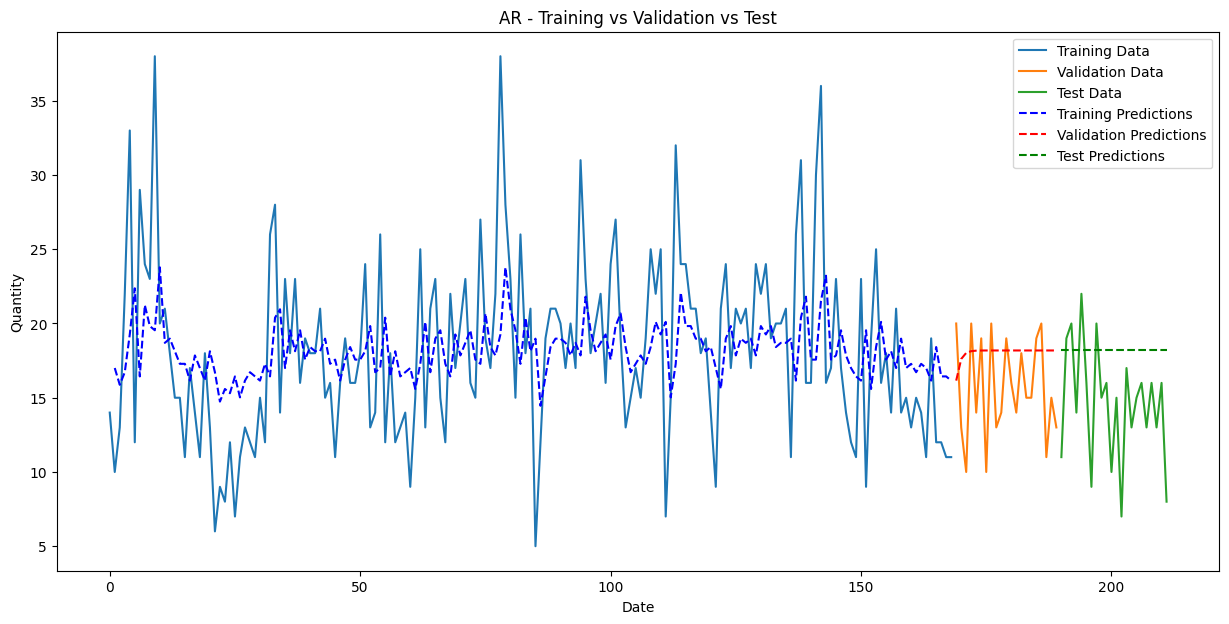

Validation Set Metrics for AR:
MSE: 		17.731 
MAE: 		3.553 
MAPE: 		27.146% 
R2: 		-0.612 
Adjusted R2: 	3.931

Test Set Metrics for AR:
MSE: 		27.603 
MAE: 		4.344 
MAPE: 		39.291% 
R2: 		-0.878 
Adjusted R2: 	4.944


In [18]:
plot_predictions_and_metrics(train_df, val_df, test_df, AR_result, model_name='AR')

### MA Model

In [19]:
# Define and fit MA model
MA_model = ARIMA(train_df['Quantity'], order=(0, 0, 1))     # MA(1) model
MA_result = MA_model.fit()

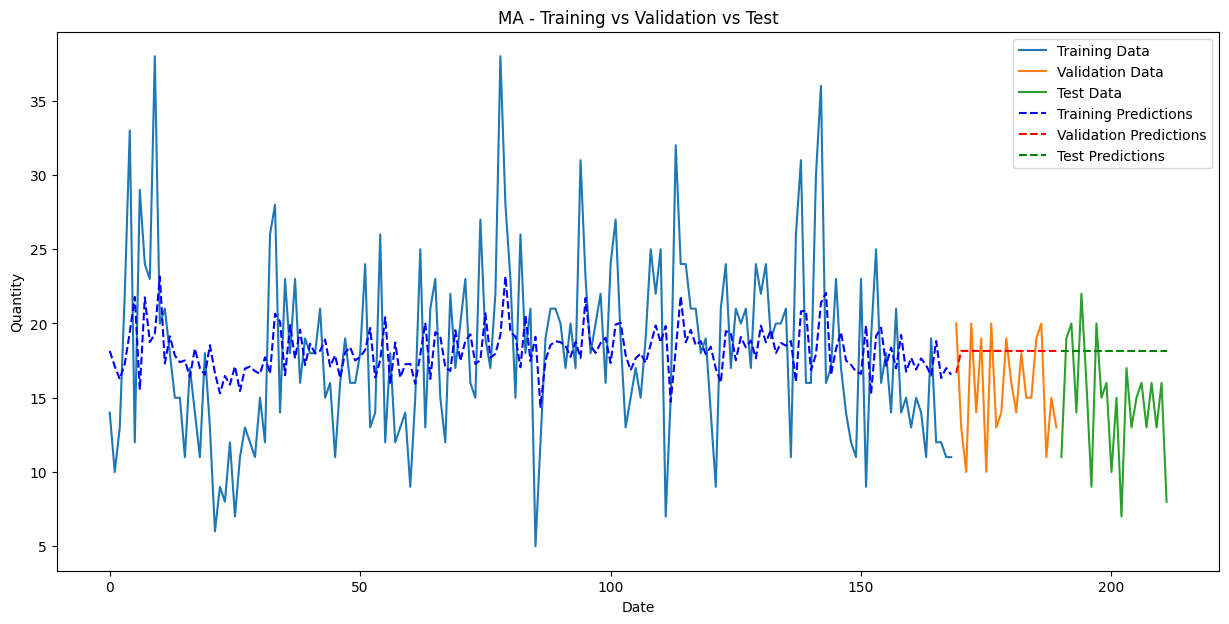

Validation Set Metrics for MA:
MSE: 		17.786 
MAE: 		3.55 
MAPE: 		27.196% 
R2: 		-0.617 
Adjusted R2: 	3.94

Test Set Metrics for MA:
MSE: 		27.386 
MAE: 		4.325 
MAPE: 		39.12% 
R2: 		-0.863 
Adjusted R2: 	4.913


In [20]:
plot_predictions_and_metrics(train_df, val_df, test_df, MA_result, model_name='MA')

### ARMA Model

In [21]:
# fitting the model
ARMA_model = ARIMA(train_df['Quantity'], order=(1, 0, 1))           # ARMA(1, 1) Model   
ARMA_result = ARMA_model.fit()                      

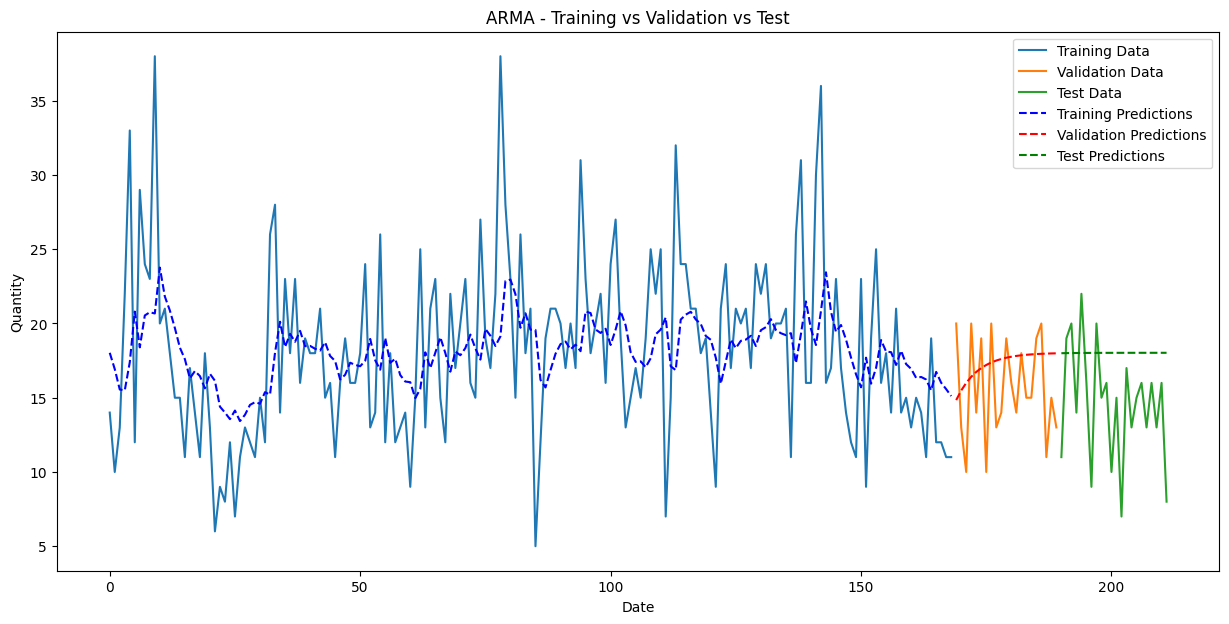

Validation Set Metrics for ARMA:
MSE: 		14.73 
MAE: 		3.372 
MAPE: 		24.796% 
R2: 		-0.339 
Adjusted R2: 	3.435

Test Set Metrics for ARMA:
MSE: 		26.473 
MAE: 		4.243 
MAPE: 		38.387% 
R2: 		-0.801 
Adjusted R2: 	4.783


In [22]:
plot_predictions_and_metrics(train_df, val_df, test_df, ARMA_result, model_name='ARMA')

### ARIMA Model

In [23]:
# fitting the model
ARIMA_model = ARIMA(train_df['Quantity'], order=(1, 0, 1))           # ARIMA(1, 0, 1) Model   
ARIMA_result = ARIMA_model.fit()    

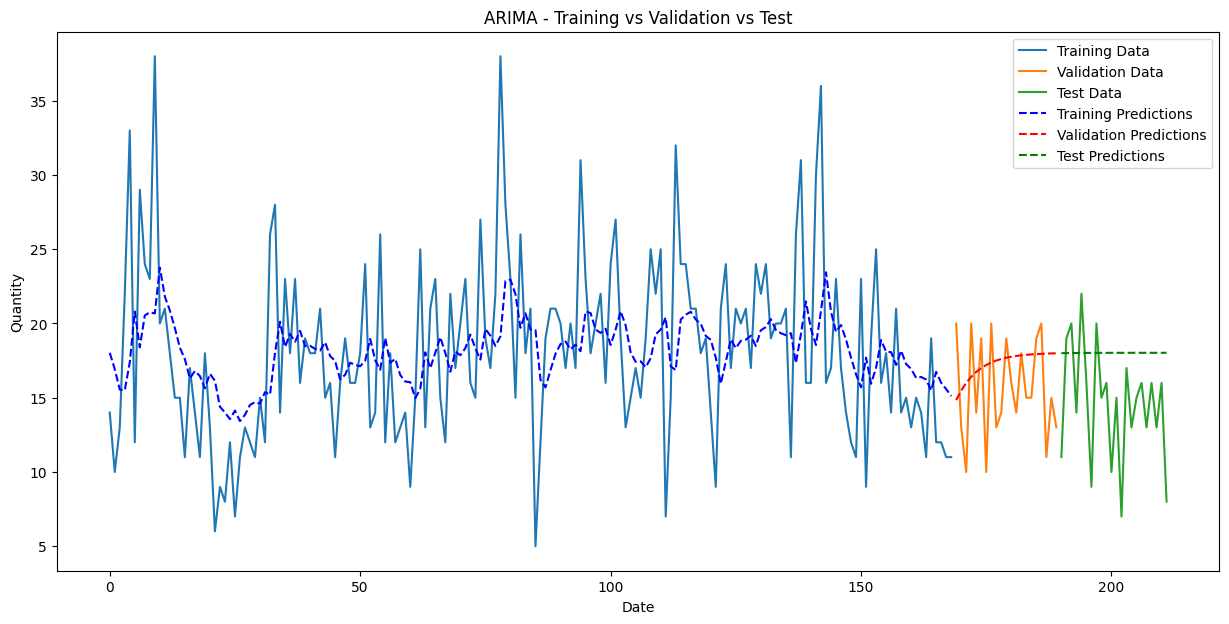

Validation Set Metrics for ARIMA:
MSE: 		14.73 
MAE: 		3.372 
MAPE: 		24.796% 
R2: 		-0.339 
Adjusted R2: 	3.435

Test Set Metrics for ARIMA:
MSE: 		26.473 
MAE: 		4.243 
MAPE: 		38.387% 
R2: 		-0.801 
Adjusted R2: 	4.783


In [24]:
plot_predictions_and_metrics(train_df, val_df, test_df, ARIMA_result, model_name='ARIMA')

### SARIMA Model

* <i>`Seasonality` taken as 6 because
    * potential pattern every 6 month or every 12 month
    * gives least error as compared to 4 or 12 month

In [25]:
# Define and fit SARIMA model
sarima_model = SARIMAX(train_df['Quantity'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))         # 6 gives the least error
sarima_model = sarima_model.fit()

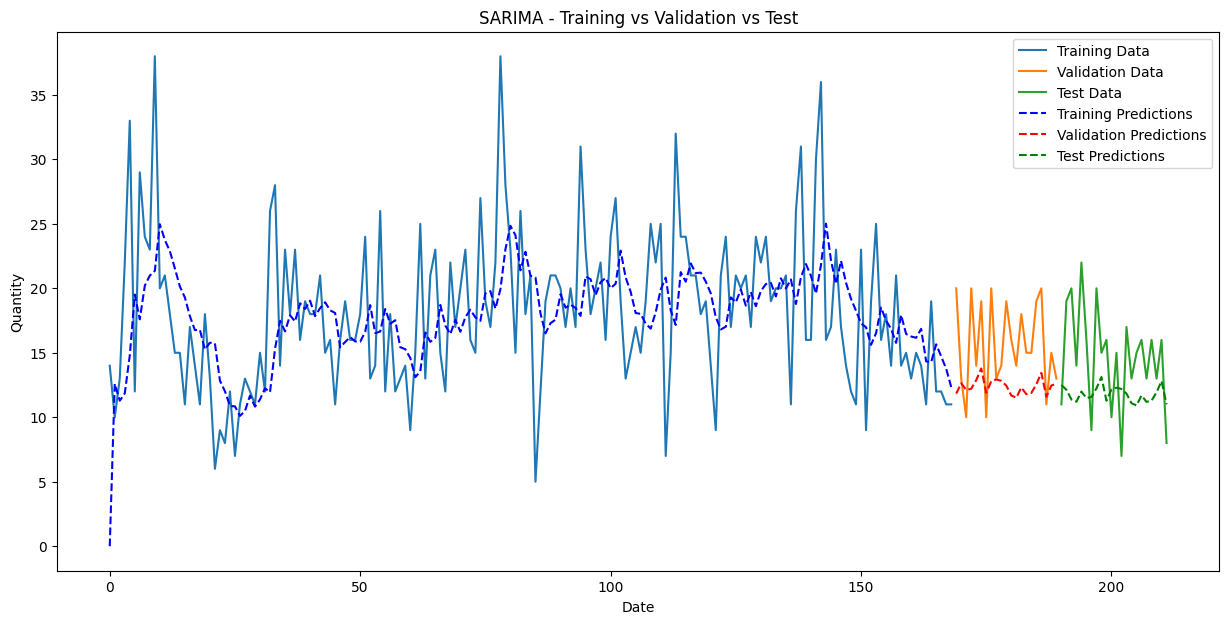

Validation Set Metrics for SARIMA:
MSE: 		20.414 
MAE: 		3.666 
MAPE: 		21.33% 
R2: 		-0.856 
Adjusted R2: 	4.375

Test Set Metrics for SARIMA:
MSE: 		22.489 
MAE: 		4.114 
MAPE: 		28.084% 
R2: 		-0.53 
Adjusted R2: 	4.213


In [26]:
plot_predictions_and_metrics(train_df, val_df, test_df, sarima_model, model_name='SARIMA')

### ARIMAX Model

In [27]:
# Drop NaN values for modeling
train_df = train_df.dropna(subset=['Clicks_stationary'])
val_df = val_df.dropna(subset=['Clicks_stationary'])
test_df = test_df.dropna(subset=['Clicks_stationary'])

* Using `Impressions` and `Clicks_stationary` together as `exogenous variable` gives the <u>least error</u>.
* Meanwhile, Taking them separately gives <u>high error<u>.

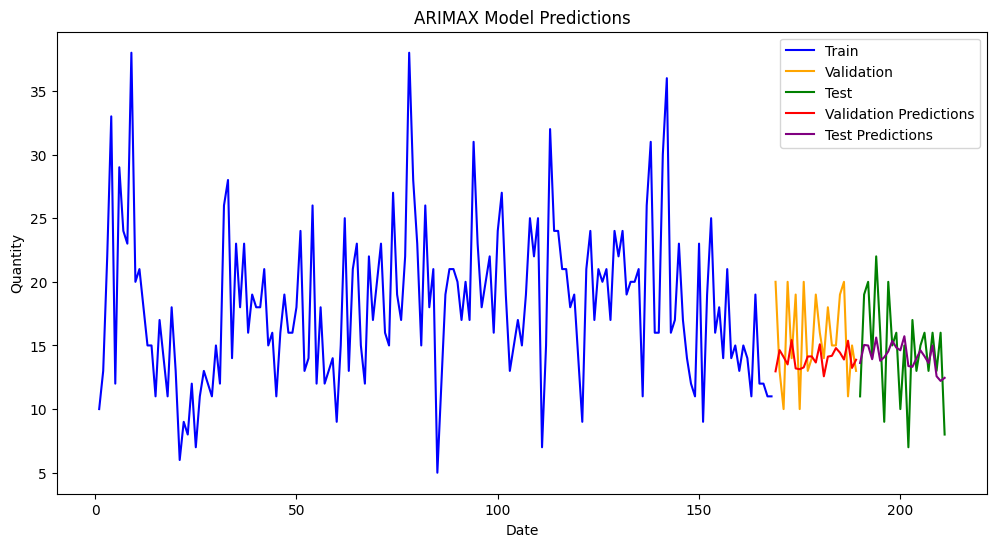

ARIMAX Validation Set Metrics:
MSE: 		15.776
MAE: 		3.231
MAPE: 		20.077%
R2: 		-0.434
Adjusted R2: 	-4.738

ARIMAX Test Set Metrics:
MSE: 		12.124
MAE: 		2.784
MAPE: 		22.076%
R2: 		0.175
Adjusted R2: 	-1.887


In [28]:
# Select exogenous variables
# "Clicks_stationary", "Impressions" ,"DayOfWeek_numeric", "Month_numeric" >>>> "Peak_day_of_week", "peak_month", "Week_of_Month" >>> "Weekend_numeric"  >>> "Peak_week"

exog_train = train_df[['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                        'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March','Month_June', 'Month_May']]
exog_val = val_df[['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                        'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March','Month_June', 'Month_May']]
exog_test = test_df[['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                        'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March','Month_June', 'Month_May']]

# Fit the ARIMAX model
arimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1)).fit()

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, arimax_model, 'ARIMAX')

### SARIMAX Model

* Using `Impressions` and `Clicks_stationary` together as `exogenous variable` gives the <u>least error</u>.
* Meanwhile, Taking them separately gives <u>high error</u>.
* `Seasonality` is taken 12 for lowest error.

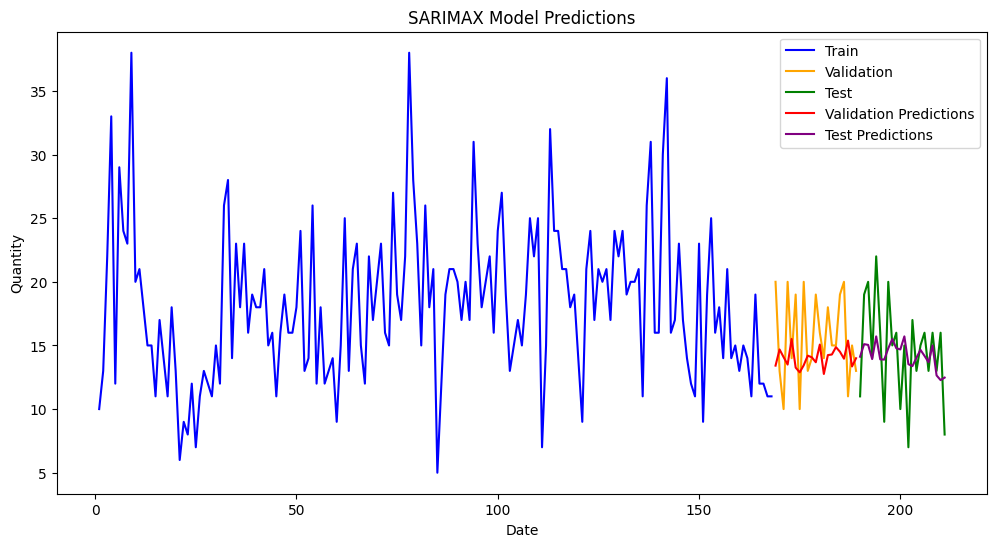

SARIMAX Validation Set Metrics:
MSE: 		15.15
MAE: 		3.166
MAPE: 		19.674%
R2: 		-0.378
Adjusted R2: 	-4.51

SARIMAX Test Set Metrics:
MSE: 		12.025
MAE: 		2.784
MAPE: 		22.206%
R2: 		0.182
Adjusted R2: 	-1.864


In [29]:
exog_train = train_df[['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                        'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March','Month_June', 'Month_May']]
exog_val = val_df[['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                        'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March','Month_June', 'Month_May']]
exog_test = test_df[['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                        'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March','Month_June', 'Month_May']]

# Fit the SARIMAX model
sarimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()              #  12 month seasonality gives least error

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, sarimax_model, 'SARIMAX')

### Multivariate Regression

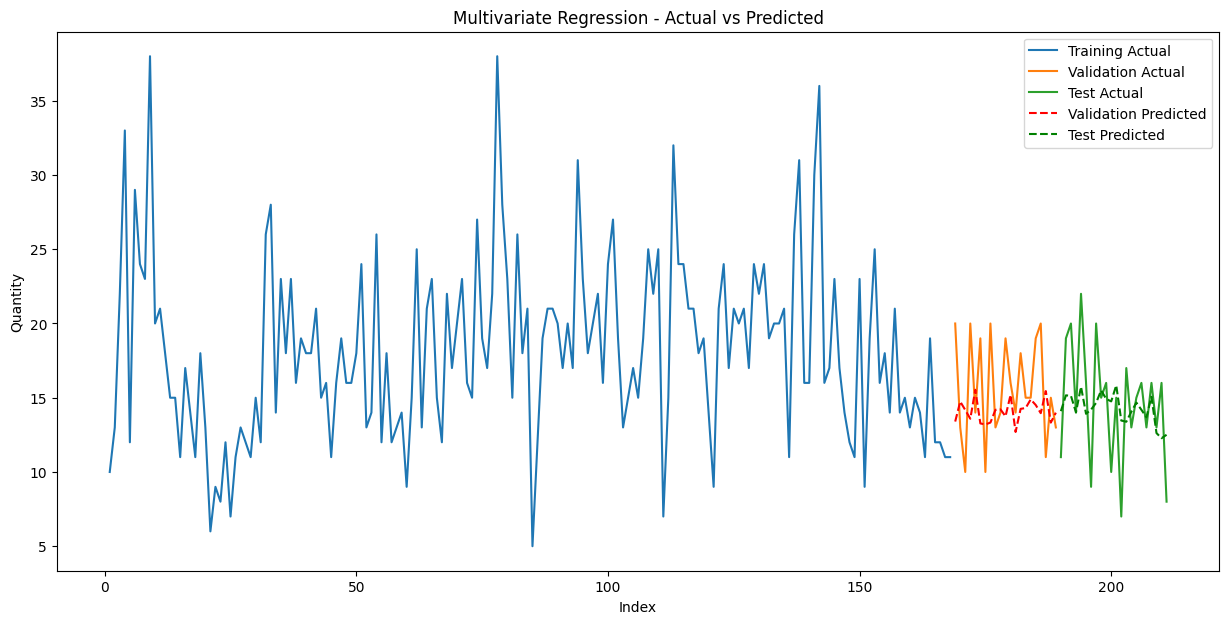


Validation Set Metrics for Multivariate Regression:
MSE: 		15.300 
MAE: 		3.192 
MAPE: 		19.937% 
R2: 		-0.391 
Adjusted R2: 	-4.565

Test Set Metrics for Multivariate Regression:
MSE: 		12.132 
MAE: 		2.790 
MAPE: 		22.310% 
R2: 		0.175 
Adjusted R2: 	-1.889


In [30]:
# features 
features = ['Clicks', 'Impressions', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
            'Weekday_Wednesday', 'Month_December', 'Month_February', 'Month_January', 'Month_March', 'Month_May', 'Month_June']

# Dependent and independent variables
y_train = train_df['Quantity']
X_train = train_df[features]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_multivariate(train_df, val_df, test_df, features, model, 'Multivariate Regression')


### COMPARISON OF MODELS


<h3> Validation Set</h3>

| Error Metrics / Models | AR     | MA     | ARMA / ARIMA  | SARIMA | ARIMAX | SARIMAX | Multivariate Regression |
|------------------------|--------|--------|---------------|--------|--------|---------|--------------------------|
| MSE                    | 18.023 | 17.871 | <span style="color:green;">14.750</span>  | 20.139 | 15.776 | <span style="color:green;">15.150</span>   | 15.300                   |
| MAE                    | 3.573  | 3.556  | 3.374         | 3.637  | 3.231  | <span style="color:green;">3.166</span>   | 3.192                    |
| MAPE                   | 26.537%| 26.257%| 24.465%       | 23.133%| 20.077%| <span style="color:green;">19.674%</span> | 19.937%                  |
| R²                     | -0.639 | -0.625 | -0.341        | -0.831 | -0.434 | -0.378  | -0.391                   |
| Adjusted R²            | 3.521  | 3.500  | 3.063         | 3.817  | -4.738 | -4.51   | -4.565                   |

<h3> Test Set </h3>

| Error Metrics / Models | AR     | MA     | ARMA / ARIMA  | SARIMA | ARIMAX | SARIMAX | Multivariate Regression |
|------------------------|--------|--------|---------------|--------|--------|---------|--------------------------|
| MSE                    | 28.025 | 27.512 | 26.682        | 22.111 | 12.124 | <span style="color:green;">12.025</span>  | 12.132                   |
| MAE                    | 4.381  | 4.336  | 4.263         | 4.078  | <span style="color:green;">2.784</span>  | <span style="color:green;">2.784</span>   | 2.790                    |
| MAPE                   | 35.412%| 35.033%| 34.414%       | 27.786%| 22.076%| <span style="color:green;">22.206%</span> | 22.310%                  |
| R²                     | -0.907 | -0.872 | -0.816        | -0.505 | 0.175  | 0.182   | 0.175                    |
| Adjusted R²            | 4.337  | 4.276  | 4.177         | 3.633  | -1.887 | -1.864  | -1.889                   |



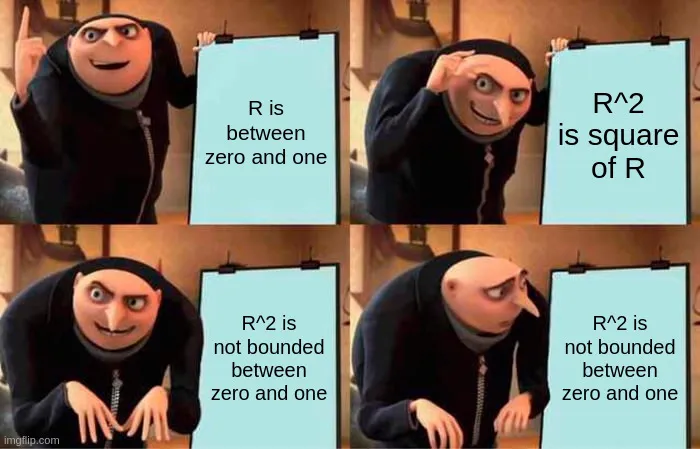

Yes, in time series forecasting data is affected by seasonality and autocorrelations. So, -ve R<sup>2</sup> isn't a problem as the MAPE value is still less.
